## Working with the brige from previous task(C60)

In [8]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img

plt.rcParams['figure.figsize'] = [12.5, 7.5]

### Creating decimated model fo faster work

In [9]:
import open3d as o3d

prepare_decimated_model = False
if prepare_decimated_model: 
    mesh = trimesh.load("../Bridge-Seg/data/Step_B_C60/C60_scaled_cleaned.obj", force='mesh')
    if not mesh.is_watertight:
        mesh.fix_normals()

    mesh = mesh.subdivide()
    mesh.export("triangulated.obj")
    mesh = o3d.io.read_triangle_mesh("triangulated.obj")
    print(mesh)

    if not mesh.has_triangle_normals():
        mesh.compute_triangle_normals()
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
        
    mesh_decimated = mesh.simplify_quadric_decimation(target_number_of_triangles=10000)
    o3d.io.write_triangle_mesh("triangulated_decimated.obj", mesh_decimated)

MESH_PATH = 'triangulated_decimated.obj'

In [10]:
IMAGE_PATH = "../Bridge-Seg/data/Step_B_C60/RawImages/DJI_20240129104036_0046.JPG"
JSON_PATH = '../Bridge-Seg/data/Step_B_C60/sfm.json'

image_name = IMAGE_PATH.split('/')[-1]
_, _, _, _, rotation, center = get_image_data_from_json(image_name, JSON_PATH)
camera_matrix, dist_coeffs = get_camera_intrinsics_from_json(image_name, JSON_PATH)

rotation = np.array(rotation, dtype=np.float32).reshape(3, 3).transpose()
center = np.array(center, dtype=np.float32).reshape(3, 1)
rotation, center = correct_meshroom_extrinsics(rotation, center)


meshes = []
world_xyz = trimesh.creation.axis()
meshes.append(world_xyz)
camera_xyz = trimesh.creation.axis()
camera_xyz.vertices = (np.matmul(rotation.transpose(), camera_xyz.vertices.transpose()) + center).transpose()
meshes.append(camera_xyz)
pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, 8192, 5460, pier)
meshes.append(pier_cutted)

scene = trimesh.Scene(meshes)
scene.show('notebook')


Above is visible from the camera part of the mesh 

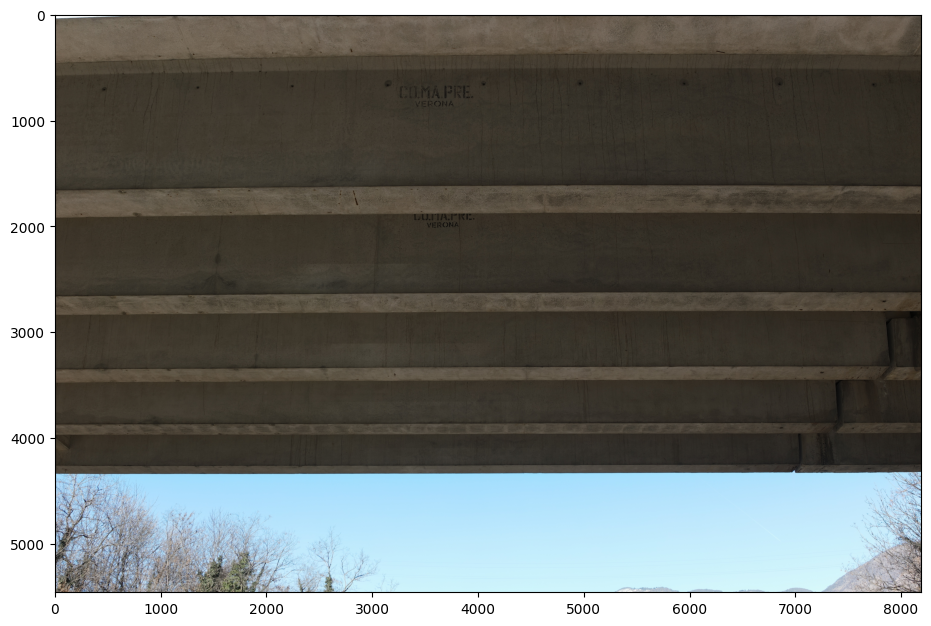

In [12]:
#camera view
img = cv.imread(IMAGE_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) 
plt.show()

Ray casting approach

In [13]:
import numpy as np
from scipy.spatial.transform import Rotation
import trimesh

def world_to_camera(points, R, t):
    """
    Transform points from world coordinates to camera coordinates.
    
    :param points: Nx3 array of points in world coordinates
    :param R: 3x3 rotation matrix
    :param t: 3x1 translation vector
    :return: Nx3 array of points in camera coordinates
    """
    return np.dot(points - t.T, R.T)

def camera_to_image(points, K):
    """
    Project points from camera coordinates to image coordinates.
    
    :param points: Nx3 array of points in camera coordinates
    :param K: 3x3 camera calibration matrix
    :return: Nx2 array of points in image coordinates
    """
    points_2d = np.dot(points, K.T)
    points_2d = points_2d[:, :2] / points_2d[:, 2:]
    return points_2d

def is_point_in_image(point_2d, image_shape):
    """
    Check if a 2D point is within the image boundaries.
    
    :param point_2d: 2D point
    :param image_shape: tuple of (height, width) of the image
    :return: Boolean indicating if the point is in the image
    """
    return (0 <= point_2d[0] < image_shape[1]) and (0 <= point_2d[1] < image_shape[0])

def get_visible_vertices(mesh, R, t, K, image_shape):
    """
    Get the vertices of the mesh that are visible in the camera view.
    
    :param mesh: trimesh.Trimesh object
    :param R: 3x3 rotation matrix
    :param t: 3x1 translation vector
    :param K: 3x3 camera calibration matrix
    :param image_shape: tuple of (height, width) of the image
    :return: List of indices of visible vertices
    """
    print(f"Mesh vertices shape: {mesh.vertices.shape}")
    print(f"R shape: {R.shape}")
    print(f"t shape: {t.shape}")
    print(f"K shape: {K.shape}")
    print(f"Image shape: {image_shape}")
    vertices_camera = world_to_camera(mesh.vertices, R, t)
    print(f"Vertices in camera coordinates shape: {vertices_camera.shape}")

    vertices_image = camera_to_image(vertices_camera, K)
    print(f"Vertices in image coordinates shape: {vertices_image.shape}")

    vertices_in_front = vertices_camera[:, 2] > 0
    print(f"Vertices in front of camera: {np.sum(vertices_in_front)}")

    vertices_in_image = np.array([is_point_in_image(p, image_shape) for p in vertices_image])
    print(f"Vertices within image boundaries: {np.sum(vertices_in_image)}")

    potentially_visible = vertices_in_front & vertices_in_image
    print(f"Potentially visible vertices: {np.sum(potentially_visible)}")

    visible_indices = []
    camera_position = -np.dot(R.T, t).flatten()
    print(f"Camera position: {camera_position}")

    for i, vertex in enumerate(mesh.vertices):
        if potentially_visible[i]:
            ray_direction = vertex - camera_position
            ray_direction /= np.linalg.norm(ray_direction)
            
            try:
                # Perform ray-mesh intersection
                locations, _, _ = mesh.ray.intersects_location(
                    ray_origins=[camera_position],
                    ray_directions=[ray_direction]
                )
                
                # Check if the first intersection is close to the vertex
                if len(locations) > 0:
                    closest_intersection = locations[0]
                    if np.allclose(closest_intersection, vertex, atol=1e-6):
                        visible_indices.append(i)
            except IndexError as e:
                print(f"IndexError at vertex {i}: {e}")
                print(f"Ray origin: {camera_position}")
                print(f"Ray direction: {ray_direction}")
                continue

    return visible_indices


image_shape = (img.shape[0], img.shape[1])  # (height, width) of the image

visible_vertices = get_visible_vertices(pier, rotation, center, camera_matrix, image_shape)

print(f"Number of visible vertices: {len(visible_vertices)}")
print("Indices of visible vertices:", visible_vertices)

Mesh vertices shape: (4908, 3)
R shape: (3, 3)
t shape: (3, 1)
K shape: (3, 3)
Image shape: (5460, 8192)
Vertices in camera coordinates shape: (4908, 3)
Vertices in image coordinates shape: (4908, 2)
Vertices in front of camera: 4908
Vertices within image boundaries: 393
Potentially visible vertices: 393
Camera position: [ 0.11378507 -1.3118654   7.013611  ]
Number of visible vertices: 116
Indices of visible vertices: [16, 54, 63, 65, 66, 69, 70, 90, 95, 171, 436, 439, 442, 443, 446, 449, 465, 522, 523, 524, 526, 620, 654, 667, 668, 670, 701, 702, 743, 756, 1047, 1053, 1054, 1056, 1058, 1060, 1062, 1078, 1085, 1093, 1097, 1102, 1103, 1126, 1513, 1515, 1537, 1541, 1566, 1573, 1576, 1580, 1602, 1614, 1628, 1649, 1660, 1702, 1711, 1712, 1713, 1733, 1734, 1735, 1756, 1757, 1784, 1789, 1857, 1861, 1867, 1886, 1900, 1903, 1905, 1906, 1908, 1920, 1923, 1935, 1936, 1966, 2115, 2312, 2320, 2321, 2355, 2372, 2373, 2376, 2401, 2415, 2437, 2454, 2455, 2466, 2470, 2471, 2472, 2475, 2476, 2514, 2536

In [15]:
import numpy as np
from scipy.spatial.transform import Rotation
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ... (previous functions remain the same) ...

def visualize_results(mesh, visible_vertices, camera_position, R):
    """
    Visualize the mesh, visible vertices, and camera position in 3D.
    
    :param mesh: trimesh.Trimesh object
    :param visible_vertices: List of indices of visible vertices
    :param camera_position: 3D position of the camera
    :param R: 3x3 rotation matrix of the camera
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all mesh vertices
    ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], 
               c='lightgray', s=1, alpha=0.5, label='All vertices')

    # Plot visible vertices
    visible_points = mesh.vertices[visible_vertices]
    ax.scatter(visible_points[:, 0], visible_points[:, 1], visible_points[:, 2], 
               c='red', s=20, label='Visible vertices')

    # Plot camera position
    ax.scatter(camera_position[0], camera_position[1], camera_position[2], 
               c='blue', s=100, label='Camera')

    # Plot camera orientation (using the rotation matrix)
    for i in range(3):
        direction = R[:, i]
        ax.quiver(camera_position[0], camera_position[1], camera_position[2],
                  direction[0], direction[1], direction[2],
                  length=0.5, color=['r', 'g', 'b'][i])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Mesh Visibility Visualization')
    ax.legend()

    # Set aspect ratio to be equal
    ax.set_box_aspect((np.ptp(mesh.vertices[:, 0]),
                       np.ptp(mesh.vertices[:, 1]),
                       np.ptp(mesh.vertices[:, 2])))

    plt.show()

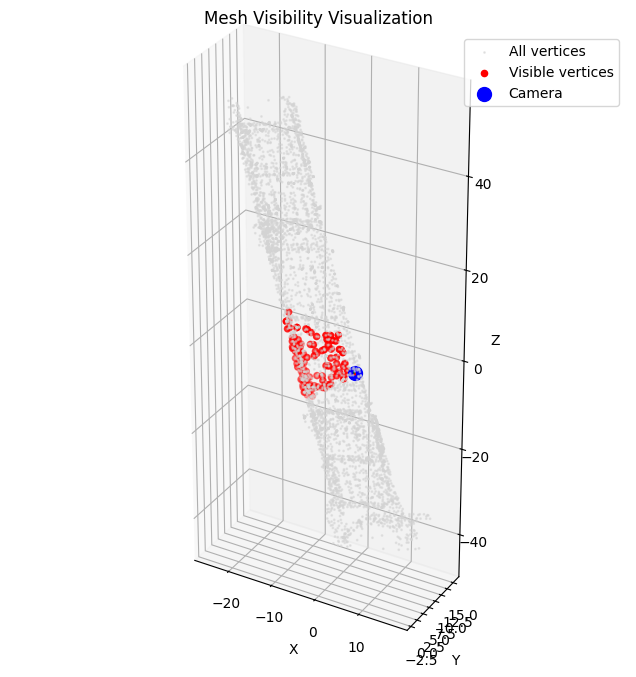

In [16]:
visualize_results(pier, visible_vertices, center, rotation)

as we can see above, that vertices on the other side of the bridge marked as visible, which shouldn't be the case

In [17]:
import plotly.graph_objects as go


camera_position = -np.dot(rotation.T, center).flatten() 

def visualize_results_interactive(mesh, visible_vertices, camera_position, R):
    """
    Create an interactive 3D visualization of the mesh, visible vertices, and camera position.
    
    :param mesh: trimesh.Trimesh object
    :param visible_vertices: List of indices of visible vertices
    :param camera_position: 3D position of the camera
    :param R: 3x3 rotation matrix of the camera
    """
    # Create scatter plot for all vertices
    all_vertices = go.Scatter3d(
        x=mesh.vertices[:, 0], y=mesh.vertices[:, 1], z=mesh.vertices[:, 2],
        mode='markers',
        marker=dict(size=2, color='lightgray', opacity=0.5),
        name='All vertices'
    )

    # Create scatter plot for visible vertices
    visible_points = mesh.vertices[visible_vertices]
    visible_scatter = go.Scatter3d(
        x=visible_points[:, 0], y=visible_points[:, 1], z=visible_points[:, 2],
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Visible vertices'
    )

    # Create scatter plot for camera position
    camera_scatter = go.Scatter3d(
        x=[camera_position[0]], y=[camera_position[1]], z=[camera_position[2]],
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Camera'
    )

    # Create lines for camera orientation
    line_traces = []
    colors = ['red', 'green', 'blue']
    for i in range(3):
        direction = R[:, i]
        end_point = camera_position + direction * 2.5
        line_traces.append(go.Scatter3d(
            x=[camera_position[0], end_point[0]],
            y=[camera_position[1], end_point[1]],
            z=[camera_position[2], end_point[2]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            name=f'Camera orientation {["X", "Y", "Z"][i]}'
        ))

    # Combine all traces
    data = [all_vertices, visible_scatter, camera_scatter] + line_traces

    max_size_x = abs(mesh.bounds[0][0] - mesh.bounds[1][0])
    max_size_y = abs(mesh.bounds[0][1] - mesh.bounds[1][1])
    max_size_z = abs(mesh.bounds[0][2] - mesh.bounds[1][2])
    
    # Set up the layout
    layout = go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        xaxis=dict(range=[center[0]-max_size_x/2, center[0]+max_size_x/2]),
        yaxis=dict(range=[center[1]-max_size_y/2, center[1]+max_size_y/2]),
        title='Interactive Mesh Visibility Visualization',
        width=1000,
        height=800
    )

    # Create and show the figure
    fig = go.Figure(data=data, layout=layout)
    fig.show()

visualize_results_interactive(pier, visible_vertices, camera_position, rotation)

same picture but in 3d 

not all visible verticies are selected

In [19]:
def get_visible_vertices_depth_buffer(mesh, R, t, K, image_shape):
    """
    Get the visible vertices of the mesh using a depth buffer.

    :param mesh: trimesh.Trimesh object
    :param R: 3x3 rotation matrix
    :param t: 3x1 translation vector
    :param K: 3x3 camera calibration matrix
    :param image_shape: tuple of (height, width) of the image
    :return: List of indices of visible vertices
    """

    # Prepare depth buffer
    depth_buffer = np.full(image_shape, np.inf)

    # Project vertices to image coordinates
    vertices_camera = world_to_camera(mesh.vertices, R, t)
    vertices_image = camera_to_image(vertices_camera, K)

    # Update depth buffer and mark visible vertices
    visible_indices = []
    print(vertices_image.shape)
    for i, (x, y) in enumerate(vertices_image):
        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
            # Calculate depth directly from z-coordinate
            depth = vertices_camera[i, 1]
            if depth < depth_buffer[int(y), int(x)]:
                depth_buffer[int(y), int(x)] = depth
                visible_indices.append(i)

    return visible_indices

image_shape = (img.shape[0], img.shape[1])  

visible_vertices = get_visible_vertices_depth_buffer(pier, rotation, center, camera_matrix, image_shape)

(4908, 2)


In [20]:
visualize_results_interactive(pier, visible_vertices, camera_position, rotation)

Depth approach  

All vertices from the other side is selected as visible(for images DJI_20240129094217_0310.JPG, DJI_20240129104036_0046.JPG)

In [21]:
def load_mesh(mesh_file):
    mesh = o3d.io.read_triangle_mesh(mesh_file)
    if not mesh.has_triangle_normals():
        mesh.compute_triangle_normals()
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    return  mesh



def is_inside_image(points, image_size):
    return np.all((points >= 0) & (points < image_size), axis=1)

def compute_depth_buffer(mesh, K, R, t, image_size):
    # Create a virtual camera
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = o3d.camera.PinholeCameraIntrinsic(
        image_size[1], image_size[0], K[0, 0], K[1, 1], K[0, 2], K[1, 2])
    cam.extrinsic = np.linalg.inv(np.vstack((np.hstack((R, t.reshape(3, 1))), [0, 0, 0, 1])))

    # Render depth image
    depth = o3d.geometry.Image(np.zeros((image_size[0], image_size[1]), dtype=np.float32))
    _ = o3d.visualization.rendering.OffscreenRenderer(image_size[1], image_size[0])
    _.scene.add_geometry(mesh)
    depth = _.render_to_depth_image(True, camera=cam)
    
    return np.asarray(depth)

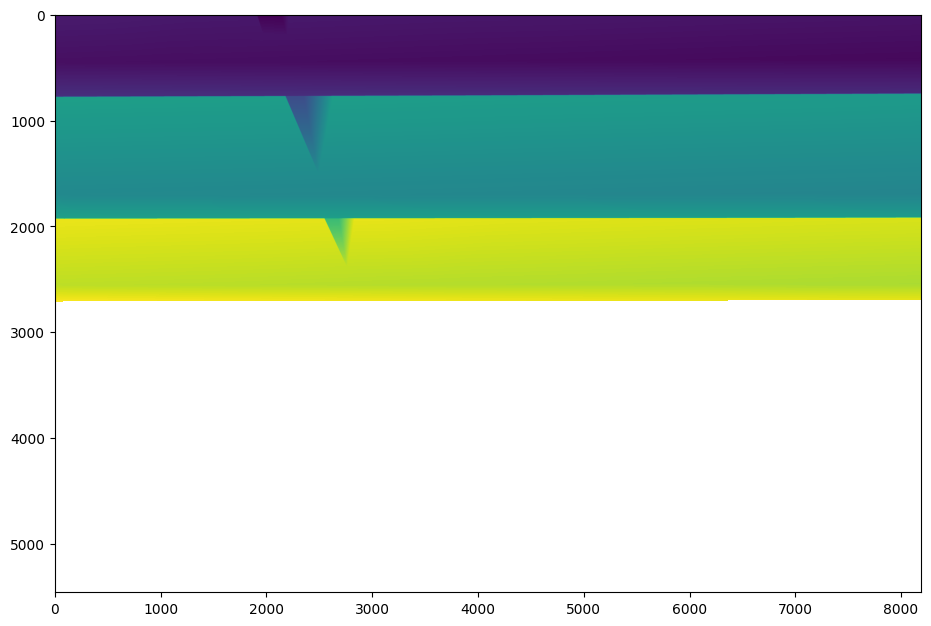

In [22]:
# open3d approach

def render_depth(
    intrins:o3d.core.Tensor,
    width:int,
    height:int,
    extrins:o3d.core.Tensor,
    tmesh:o3d.t.geometry.TriangleMesh
)->np.ndarray:
    """
    Render depth from mesh file

    Parameters
    ----------
    intrins : o3d.core.Tensor
        Camera Intrinsics matrix K: 3x3
    width : int
        image width
    height : int
        image height
    extrins : o3d.core.Tensor
        camera extrinsics matrix 4x4
    tmesh : o3d.t.geometry.TriangleMesh
        TriangleMesh

    Returns
    -------
    np.ndarray
        Rendred depth image
    """
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(tmesh)
    
    rays = scene.create_rays_pinhole(
        intrinsic_matrix=intrins,
        extrinsic_matrix=extrins,
        width_px=width, height_px=height
    )
    
    ans = scene.cast_rays(rays)
    t_hit = ans["t_hit"].numpy()

    return t_hit




if __name__=="__main__":
    import os
    mesh_path = 'triangulated_decimated.obj'
    mesh = o3d.t.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()
    

    width_  =  img.shape[1]
    height_ = img.shape[0]
    # root2cam 4x4
    extrens = np.eye(4)
    extrens[:3, :3] = rotation
    extrens[:3, 3] = np.squeeze(center)

    intrins_t = o3d.core.Tensor(camera_matrix)
    extrins_t = o3d.core.Tensor(extrens)
    
    rendered_depth = render_depth(
        intrins=intrins_t, 
        width=width_, 
        height=height_, 
        extrins = extrins_t, 
        tmesh=mesh
    )
    
    plt.imshow(rendered_depth)
    plt.show()

above is the depth map of visible part of the mesh

In [23]:
import numpy as np
import open3d as o3d
import trimesh

def get_visible_vertices_open3d(trimesh_obj, K, R, t, image_size):
    # Convert trimesh to Open3D mesh
    vertices = np.asarray(trimesh_obj.vertices)
    faces = np.asarray(trimesh_obj.faces)
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(vertices)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(faces)
    
    # Create extrinsic matrix
    extrins = np.eye(4)
    extrins[:3, :3] = R
    extrins[:3, 3] = np.squeeze(t)

    intrins_t = o3d.core.Tensor(K)
    extrins_t = o3d.core.Tensor(extrins)
    
    # Render depth map
    rendered_depth = render_depth(
        intrins=intrins_t, 
        width=image_size[1], 
        height=image_size[0], 
        extrins=extrins_t, 
        tmesh=o3d.t.geometry.TriangleMesh.from_legacy(o3d_mesh)
    )
    
    # Project vertices
    vertices_homogeneous = np.hstack((vertices, np.ones((vertices.shape[0], 1))))
    P = K @ np.hstack((R, t))
    projected_points = P @ vertices_homogeneous.T
    projected_points = projected_points / projected_points[2]
    projected_points = projected_points[:2].T

    # Check visibility
    visible_mask = np.zeros(vertices.shape[0], dtype=bool)
    for i, (x, y) in enumerate(projected_points):
        x, y = int(x), int(y)
        if 0 <= x < image_size[1] and 0 <= y < image_size[0]:
            vertex_depth = np.linalg.norm(R @ vertices[i] + t.flatten())
            if vertex_depth <= rendered_depth[y, x] + 1e-3:  # Small epsilon for numerical stability
                visible_mask[i] = True
    
    return np.where(visible_mask)[0]

# Usage
image_shape = (img.shape[0], img.shape[1])
visible_vertices = get_visible_vertices_open3d(pier, camera_matrix, rotation, center, image_shape)

# Visualize results
visualize_results_interactive(pier, visible_vertices, camera_position, rotation)

not looking good

In [28]:
def get_visible_vertices_open3d(trimesh_obj, K, R, t, image_size):
    vertices = np.asarray(trimesh_obj.vertices)
    faces = np.asarray(trimesh_obj.faces)
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(vertices)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(faces)
    
    # Create extrinsic matrix
    extrins = np.eye(4)
    extrins[:3, :3] = R
    extrins[:3, 3] = np.squeeze(t)

    intrins_t = o3d.core.Tensor(K)
    extrins_t = o3d.core.Tensor(extrins)
    
    # Render depth map
    rendered_depth = render_depth(
        intrins=intrins_t, 
        width=image_size[1], 
        height=image_size[0], 
        extrins=extrins_t, 
        tmesh=o3d.t.geometry.TriangleMesh.from_legacy(o3d_mesh)
    )
    
    # Project vertices
    vertices_homogeneous = np.hstack((vertices, np.ones((vertices.shape[0], 1))))
    P = K @ np.hstack((R, t))
    projected_points = P @ vertices_homogeneous.T
    projected_points = projected_points[:2] / projected_points[2]
    projected_points = projected_points.T

    # Check visibility
    visible_mask = np.zeros(vertices.shape[0], dtype=bool)
    margin = 1  # Add a small margin when checking image bounds
    depth_epsilon = 3e-1  # Increase epsilon for depth comparison
    
    for i, (x, y) in enumerate(projected_points):
        x, y = int(round(x)), int(round(y))
        if -margin <= x < image_size[1] + margin and -margin <= y < image_size[0] + margin:
            x = max(0, min(x, image_size[1] - 1))
            y = max(0, min(y, image_size[0] - 1))
            vertex_depth = np.linalg.norm(R @ vertices[i] + t.flatten())
            if vertex_depth <= rendered_depth[y, x] + depth_epsilon:
                visible_mask[i] = True
    
    return np.where(visible_mask)[0]

# Usage
image_shape = (img.shape[0], img.shape[1])
visible_vertices = get_visible_vertices_open3d(pier, camera_matrix, rotation, center, image_shape)

# Visualize results
visualize_results_interactive(pier, visible_vertices, camera_position, rotation)

Better. I think looks good enough to work with